
# tSNE with jets!

In [4]:
import os
import sys
sys.path.append(os.path.realpath('..'))
#os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
#os.environ["CUDA_VISIBLE_DEVICES"]="6"
import tools
import EnergyFlow.ef_tools as ef_tools
import numpy as np

with open("../filepath.txt", 'r') as f:
    filename = f.read().strip("\n")   

# load data
if False: #os.path.exists("X.npy"):
    X = np.load("X.npy", allow_pickle=True)
    y = np.load("y.npy", allow_pickle=True)
else:
    X, y = ef_tools.open_file(filename, njets=10)
    np.save("X.npy", X, allow_pickle=True)
    np.save("y.npy", y, allow_pickle=True)

padding arrays
done padding
777150 events total
444528 events after ensuring first 3 are correctly tagged
307055 events after ensuring we only have 3 tags
303931 events after ensuring there is at most 1 untagged jet


Loading model... 
Using architecture: ../models/architecture_same_filters.json 
and weights: ../models/weights_same_filters.h5
303931


100%|██████████| 303931/303931 [00:02<00:00, 141947.84it/s]


overall accuracy: 47.71 percent
ignoring 0.0 percent of 303931 events


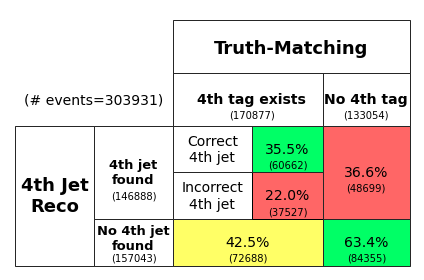

In [5]:
import importlib
import ptetaphi_nn
import awkward
import uproot_methods as urm

importlib.reload(ptetaphi_nn)

events = awkward.Table()
# add data to table
events['resolved_lv'] = urm.TLorentzVectorArray.from_ptetaphie(X[:,:,0], X[:,:,1], X[:,:,2],X[:,:,3])
truths = y[:,:-1].copy().astype(int)
truths[:,:3] = 1 
events['truth'] = truths  # no no-jet jet
tags = X[:,:,4]
events['tag'] = tags

nn = ptetaphi_nn.PtEtaPhiNN(events, load=("../models/architecture_same_filters.json", "../models/weights_same_filters.h5"), njets=X.shape[1])

print(len(events))

selections = nn.evaluate(events)

In [23]:
from tqdm import tqdm

# total number of events
n_events = len(truths)
# truths, tags selections are arrays from above,
# jet_nos[i] = 0,1,2,3,4,5, ... selected jet for each event
jet_nos = np.zeros(n_events, dtype=int)

# this loop is almost identical to the one in tools.evaluate_model
for i in tqdm(range(n_events)):
    selection = selections[i]
    selection_index = np.where(selection == 1)
    if len(selection_index[0]) == 0:
        jet_nos[i] = -1
    else:
        jet_nos[i] = selection_index[0][0]

print("\r", jet_nos)


100%|██████████| 303931/303931 [00:01<00:00, 242218.82it/s]

 [-1 -1 -1 ... -1 -1 -1]


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.017s...
[t-SNE] Computed neighbors for 5000 samples in 0.893s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 61.541069
[t-SNE] KL divergence after 250 iterations with early exaggeration: 89.370087
[t-SNE] KL divergence after 82050 iterations: 1.593832
(5000, 2)


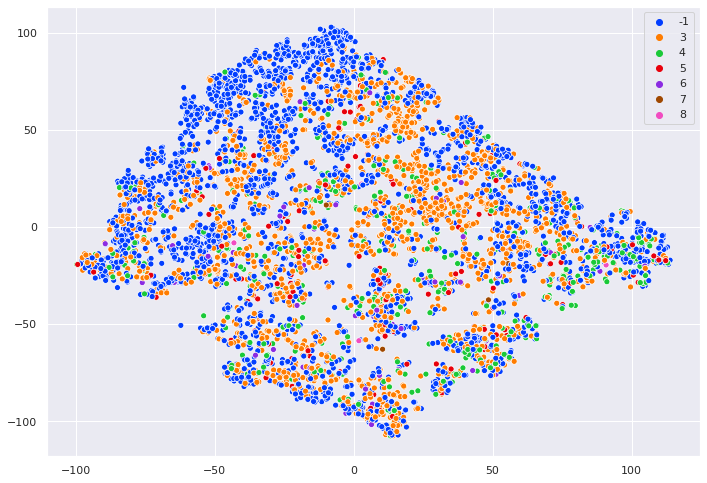

In [28]:
n = 5000

import numpy as np
from sklearn.datasets import load_digits
from scipy.spatial.distance import pdist
from sklearn.manifold.t_sne import _joint_probabilities
from scipy import linalg
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import squareform
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
palette = sns.color_palette("bright", len(np.unique(jet_nos[:n])))

tsne = TSNE(perplexity=30, verbose=True, learning_rate=1, n_iter=100000)
# :1000 so this doesn't take eons
x_2d = np.array([x.flatten() for x in X])[:n, :]

X_embedded = tsne.fit_transform(x_2d)
print(X_embedded.shape)

sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=jet_nos[:n], legend='full', palette=palette)

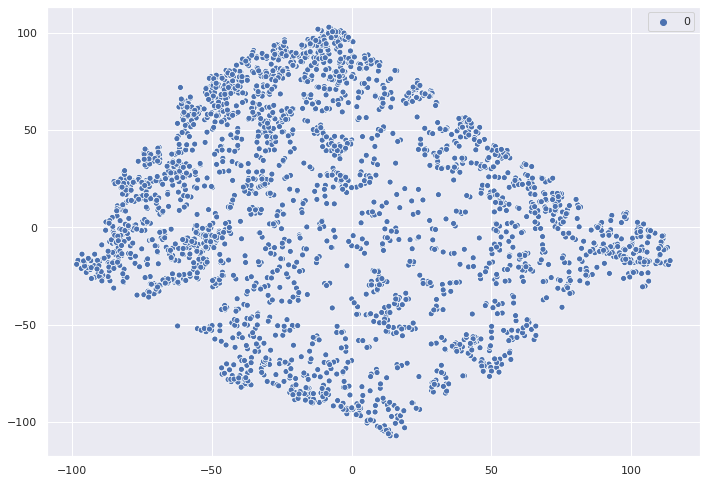

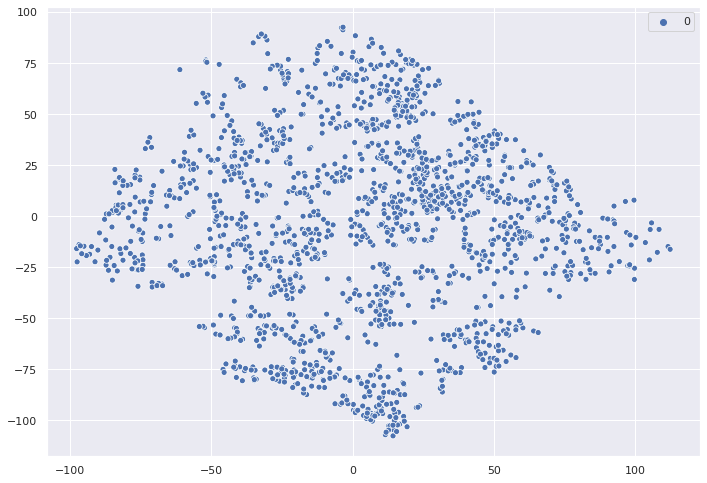

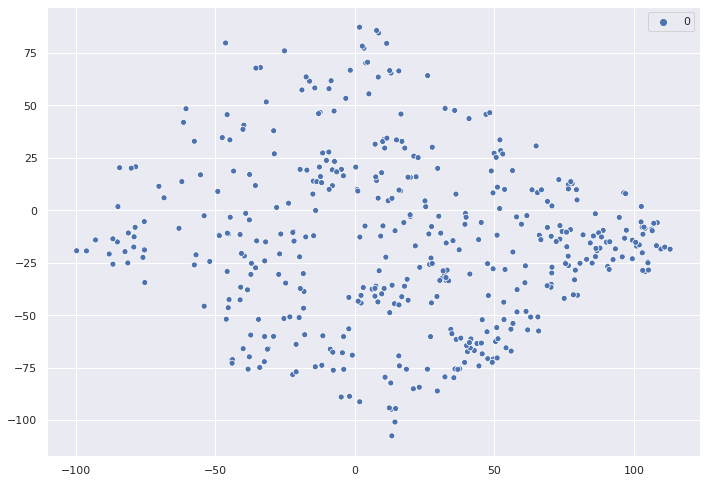

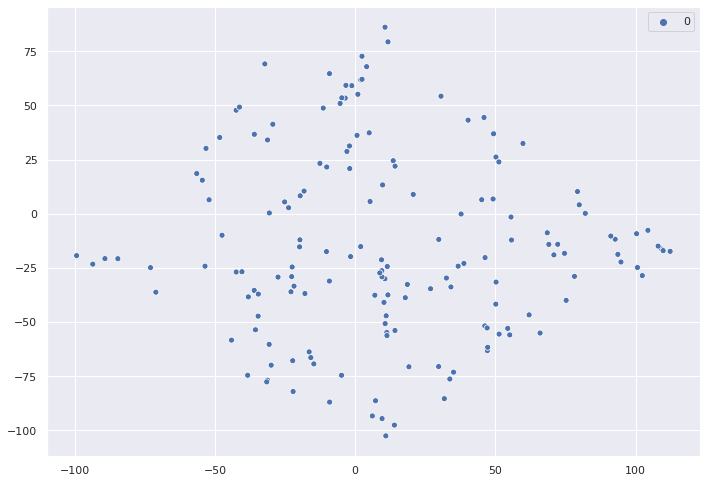

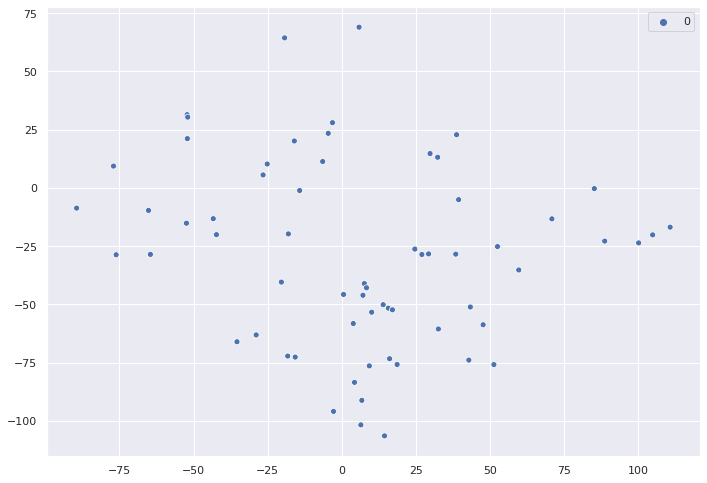

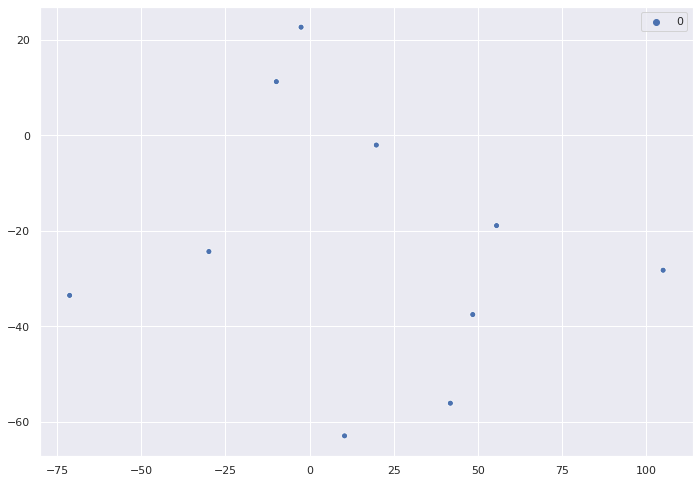

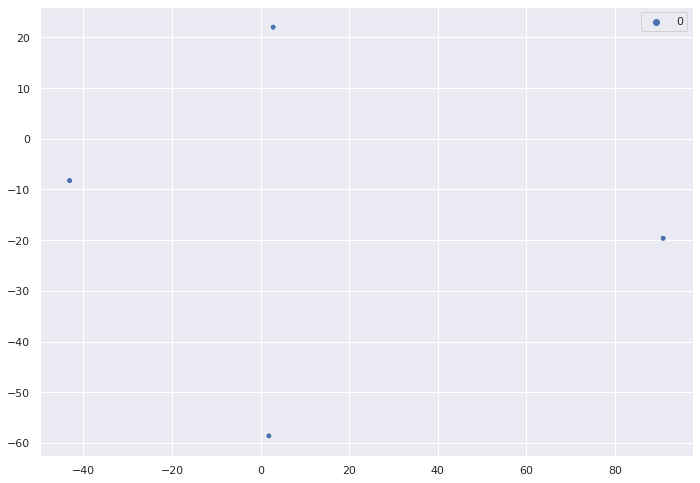

In [37]:
nos = jet_nos[:n]
for no in np.unique(jet_nos[:n]):
    x0 = X_embedded[nos==no,0]
    x1 = X_embedded[nos==no,1]
    c = nos[nos==no]
    sns.scatterplot(x0, x1, hue=0)
    plt.show()